In [47]:
def image_rotation(image, angle, show = False):
    """
    This function rotates the combined image by a user specified angle amount, if the angle specified is 1, the result is that the combined image is rotated by one degree.
    
    Parameters:
        image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        """
    pil_format = Image.fromarray(image)
    rotated_image = pil_format.rotate(angle)
    rotated_image = np.array(rotated_image)
    
    if show == True:
        #display the rotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(rotated_image, cmap='viridis')
        plt.title("Rotated Image")
        plt.show()
    return rotated_image

#Create a function that takes the combined image and integrates it using the azimuthal integrator and displays the 1D image
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, show = False, radial_range = None):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = p1.mean()
    poni2 = p2.mean()
    
    
    ai = AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask)
    
    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I
    

def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 1000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()
    
    #create a loop that rotates the combined image by the user specified angle amount and integrates the image
    for i in range(0, 360, angle_of_rotation):
        #rotate the mask for the combined image
        rotated_image = image_rotation(combined_image, i);
    
        
        #integrate the rotated image
        q, I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show = False, radial_range = (0, 10));
        
        #add the 1D integration to the dataframe
        df[i] = I
        
        #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5
    plt.figure(figsize=(10, 10))
    for j in range(0, 360, angle_of_rotation):
            plt.plot(q, (df[j]+ j*.01), alpha = .55, c = 'black')
    plt.xlabel('q A $^(-1)$')
    plt.ylabel('Intensity')
    plt.title("Waterfall Plot of Rotated 1D X-Ray Diffraction Images")
    plt.show()        
    return q, df

In [27]:
def make_masks(array, slices):
    masks = []
    for i in slices:
        masks.append(masking.generate_mask_slices(array, .5, i, offset = 7))
        print('Mask with {} slices created'.format(i))
    return masks

In [3]:
def generate_mask_slices(array, width, num_slices, offset = 5):
    
    ''' Returns a mask with multiple slices of the chi array left unmasked to be used for integration.
    
    Keyword arguments:
    chi_array -- chi array
    width -- width of the slice in degrees
    num_slices -- number of slices
    offset -- offset between slices in degrees
    plot -- if True, plots the mask (default False)
    
    '''
    mask_list = []
    
    # Create masks for the positive values
    for i in range(num_slices):
        start = i * (width + offset)
        end = start + width
        mask_list.append(ma.masked_inside(array, start, end))

    # Create masks for the negative values
    for i in range(num_slices):
        start = - (i + 1) * (width + offset)
        end = start - width
        mask_list.append(ma.masked_inside(array, start, end))
    
    #add all genrated masks together
    
    print(mask_list)

    combined_mask = mask_list[0]
    for mask in mask_list[1:]:
        combined_mask += mask
        
    inverted_mask = ~combined_mask.mask 
    plt.figure()
    plt.imshow(~combined_mask.mask)
    
    return inverted_mask

In [45]:
import IsoDAT2D as iso
import SimDAT2D as sim
import dask.array as da
import dask.dataframe as dd
import masking
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
Au


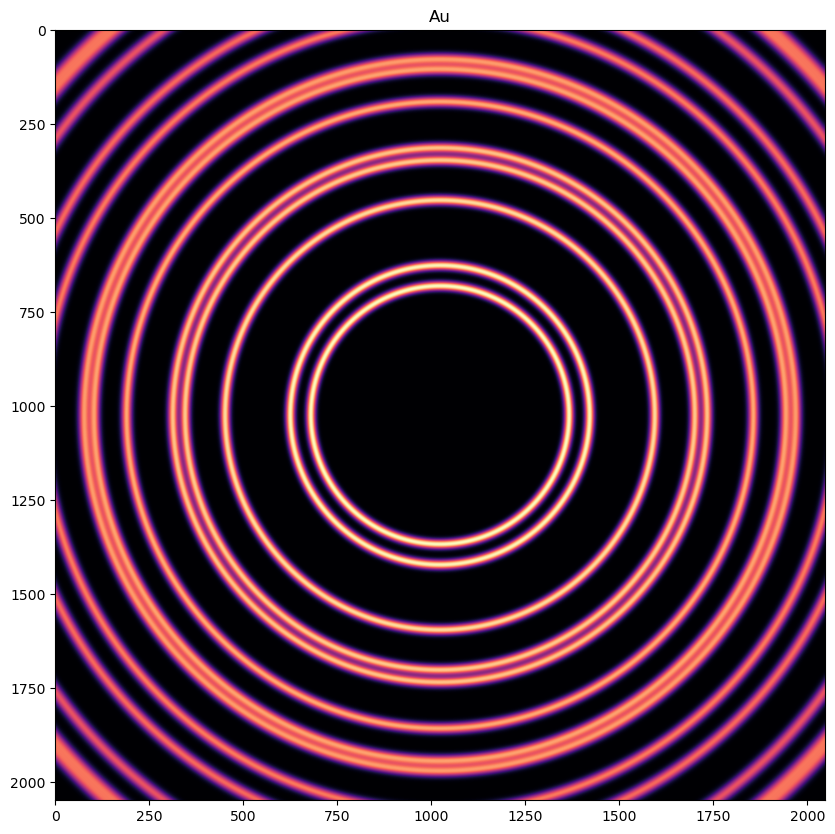

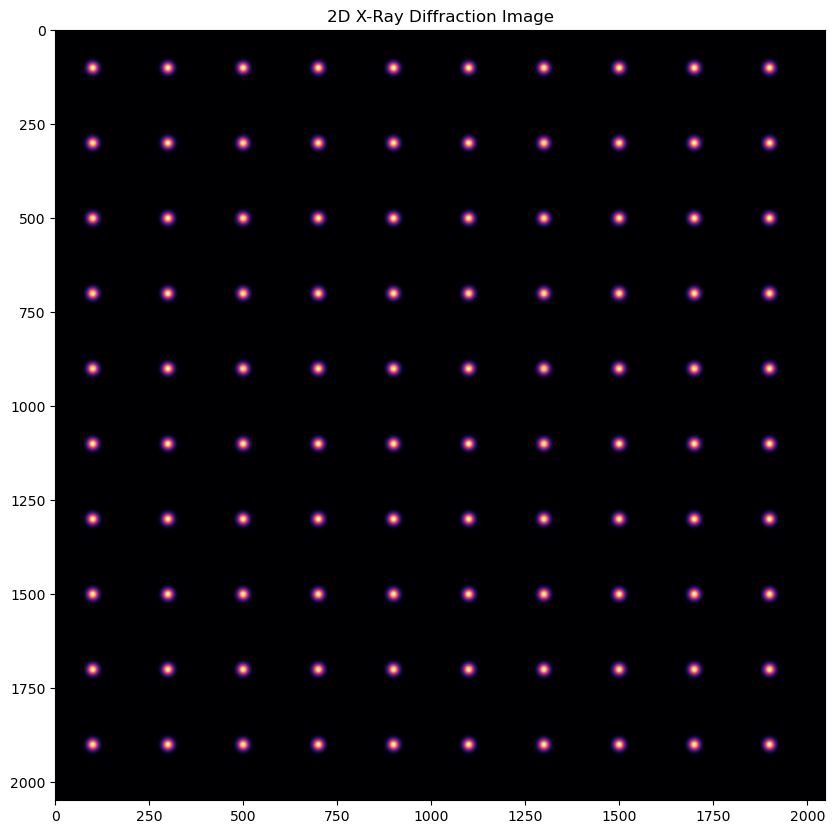

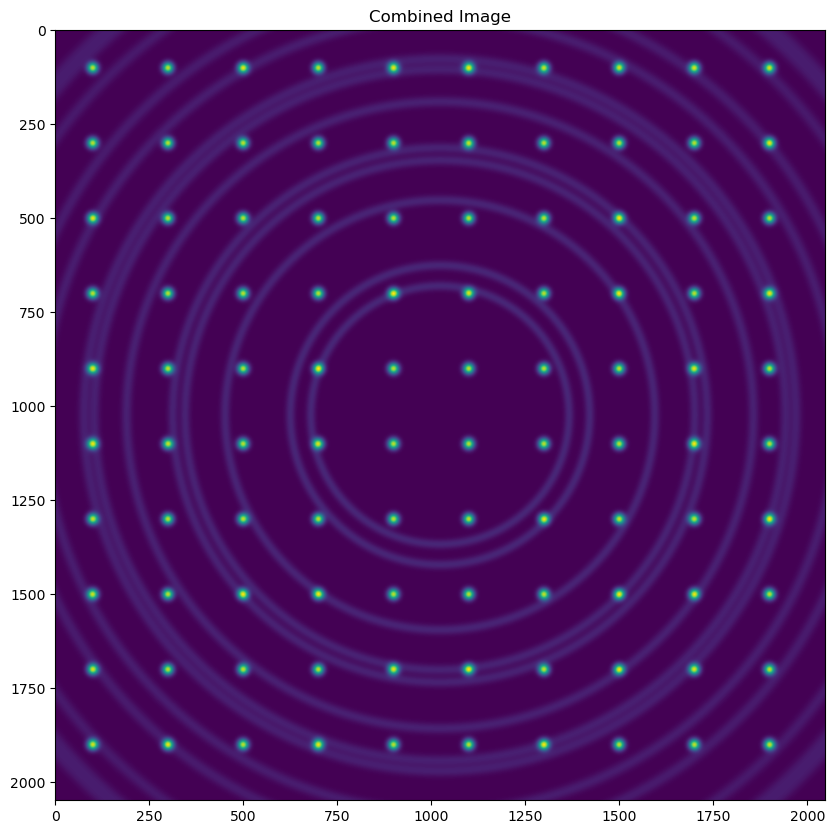

In [136]:
data = sim.combine_image(sim.create_isotropic(.4, .4e-10, cmap = 'magma'), sim.create_anisotropic(15, 10, 200, size = 200, cmap = 'magma')*8)

In [133]:
array, ai_pe = masking.make_chi_array(data, .4, .4e-10)

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
Au


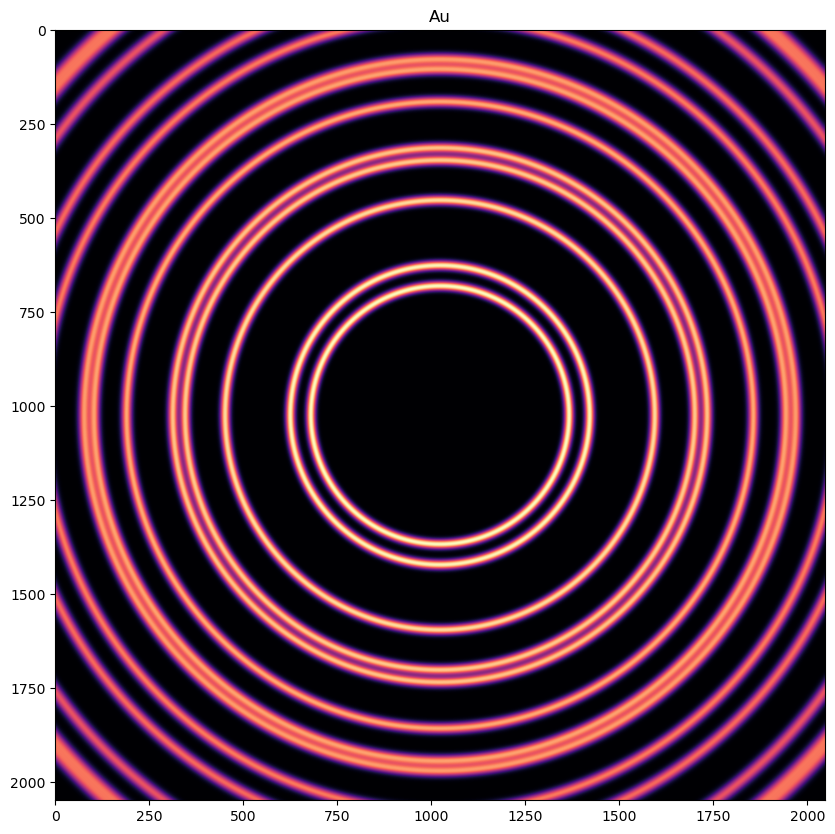

In [134]:
pure = sim.create_isotropic(.4, .4e-10, cmap = 'magma')

[masked_array(
  data=[[-135.00017100451313, -134.97216689027152, -134.94413749056966,
         ..., -45.05619265132289, -45.02816084175853, -45.00015640746067],
        [-135.02817528583523, -135.0001711717571, -134.97214174542282,
         ..., -45.02818839694317, -45.00015656042945, -44.97215212598207],
        [-135.05620485260465, -135.02820076548636, -135.000171339316,
         ..., -45.00015880320792, -44.972126966543236,
         -44.94412255874272],
        ...,
        [135.0561923155709, 135.02818822843457, 135.00015880225814, ...,
         45.00017134026579, 44.97213950359518, 44.94413509577675],
        [135.0281606735792, 135.000156559494, 134.9721271331666, ...,
         45.028203009199196, 45.00017117269255, 44.972166738238265],
        [135.00015640652705, 134.97215229229232, 134.94412289261135, ...,
         45.05620724928089, 45.028175439737566, 45.00017100544677]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

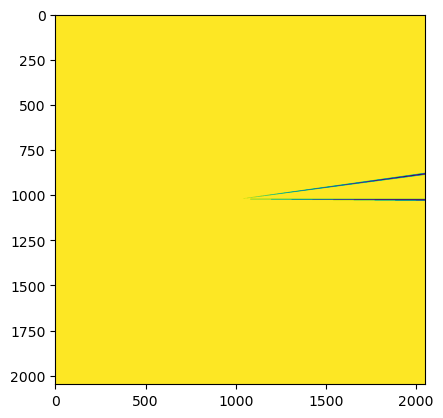

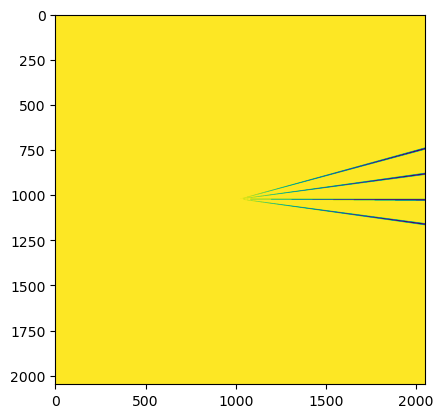

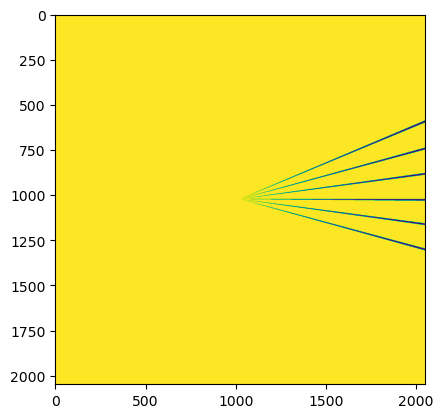

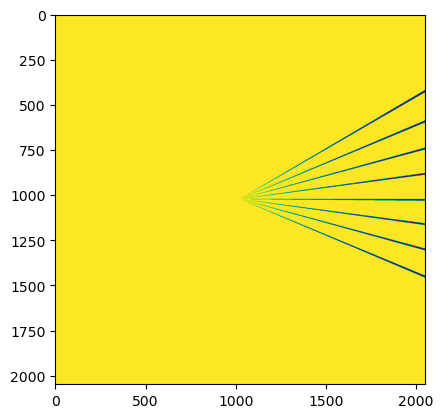

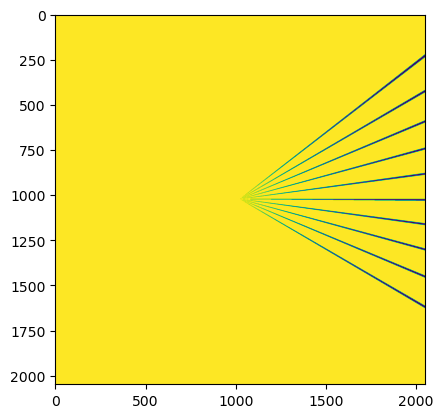

In [29]:
masks = make_masks(array, [1,2,3, 4, 5])

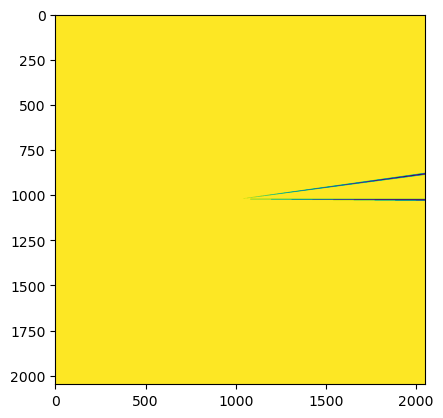

In [40]:
plt.imshow(masks[0])

mask_one = masks[0]

/scratch/local/25136315/ipykernel_205984/633811532.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


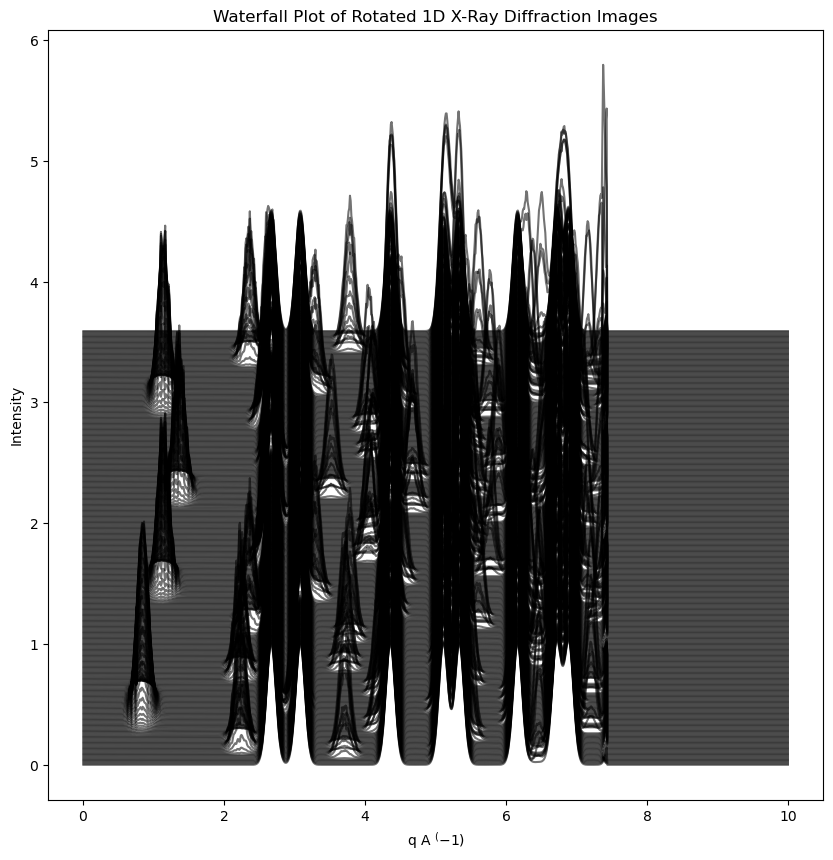

In [48]:
ints = rotate_and_integrate(data, 1, .4, .4e-10, mask = mask_one)

In [50]:
mask_two = masks[1]
mask_three = masks[2]
mask_four = masks[3]
mask_five = masks[4]

/scratch/local/25136315/ipykernel_205984/633811532.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


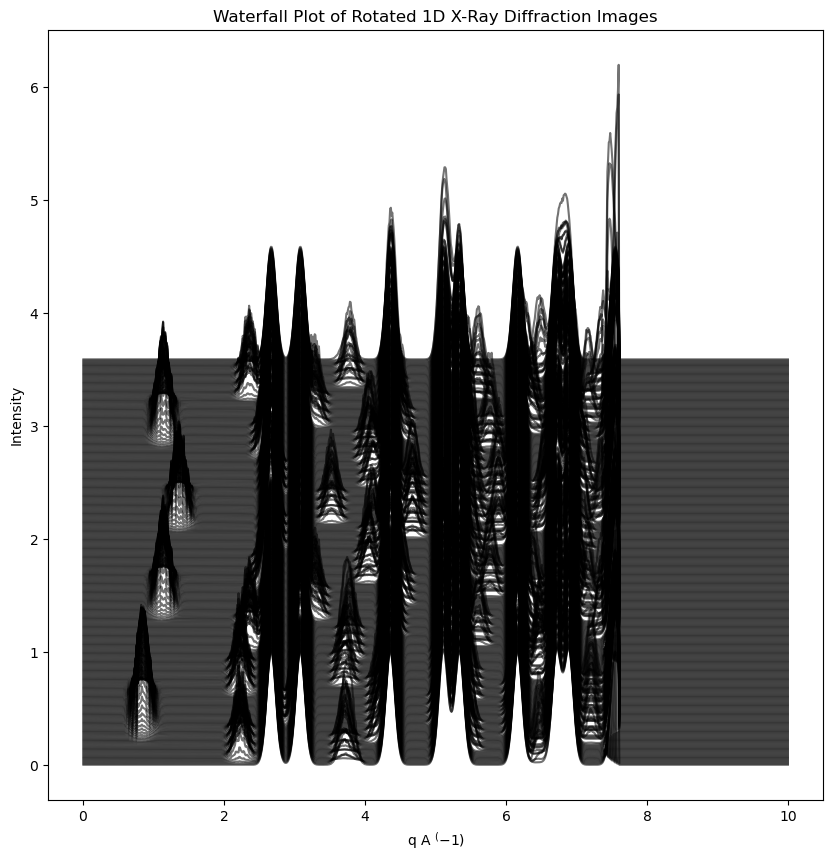

In [51]:
ints1 = rotate_and_integrate(data, 1, .4, .4e-10, mask = mask_two)

/scratch/local/25136315/ipykernel_205984/633811532.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


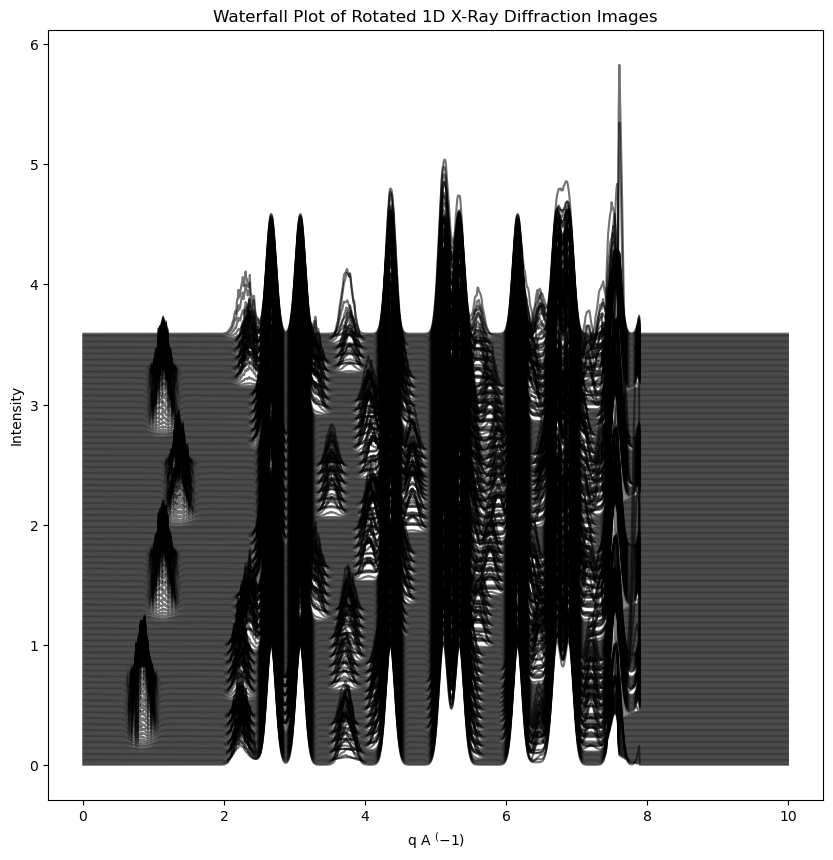

In [52]:
ints2 = rotate_and_integrate(data, 1, .4, .4e-10, mask = mask_three)

/scratch/local/25136315/ipykernel_205984/633811532.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


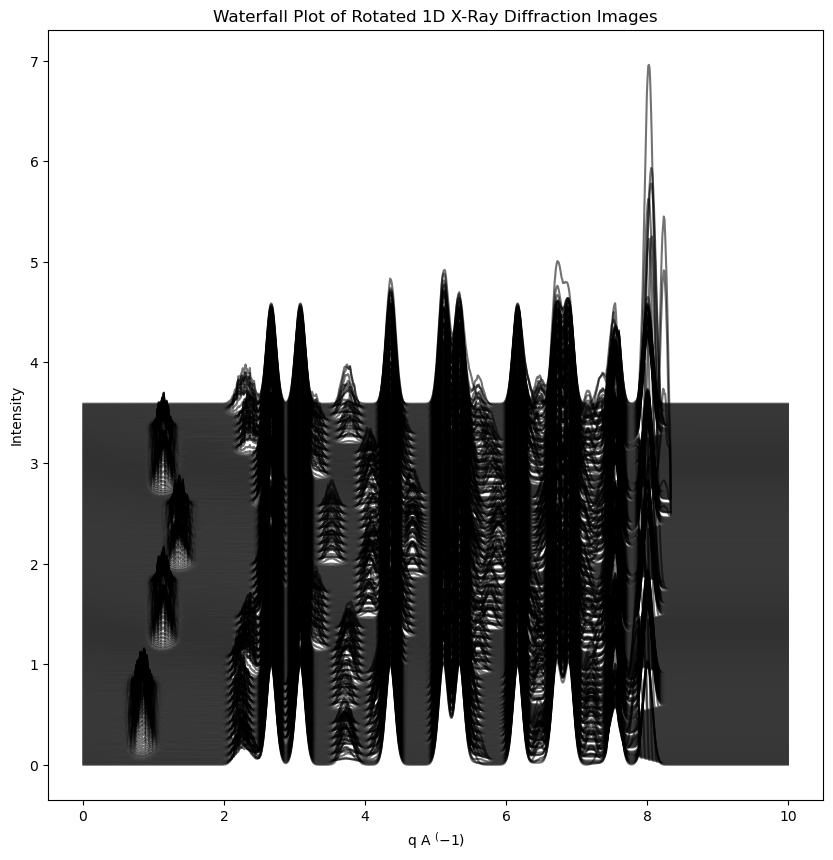

In [53]:
ints3 = rotate_and_integrate(data, 1, .4, .4e-10, mask = mask_four)

/scratch/local/25136315/ipykernel_205984/633811532.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


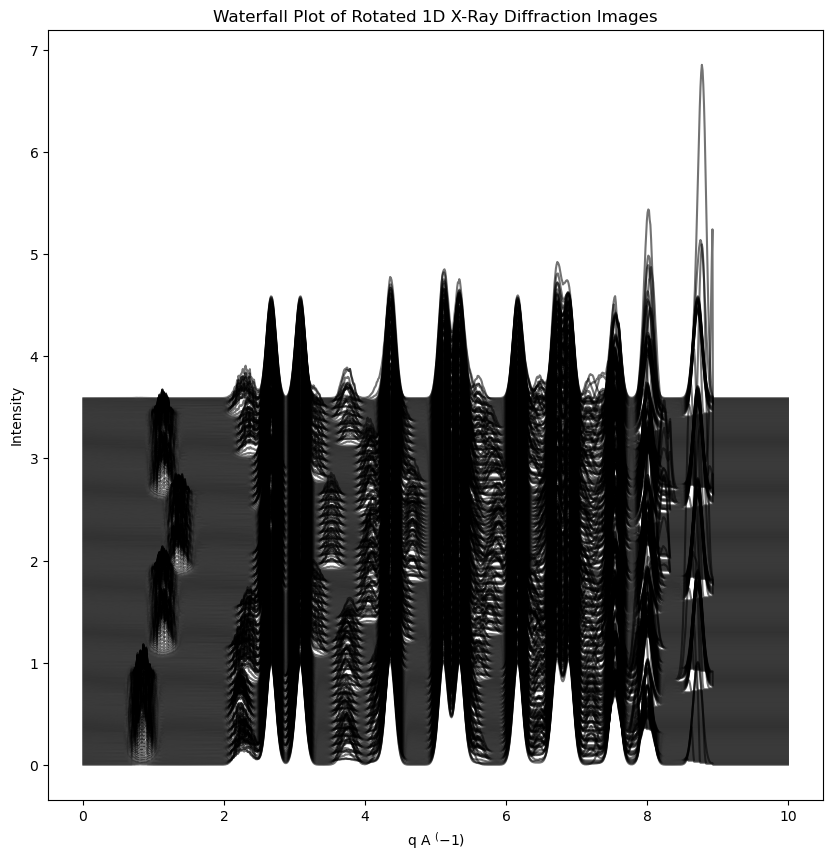

In [54]:
ints4 = rotate_and_integrate(data, 1, .4, .4e-10, mask = mask_five)

In [57]:
import pandas as pd

In [67]:
_, actual_ints = ints
_, actual_ints1 = ints1
_, actual_ints2 = ints2
_, actual_ints3 = ints3
_, actual_ints4 = ints4

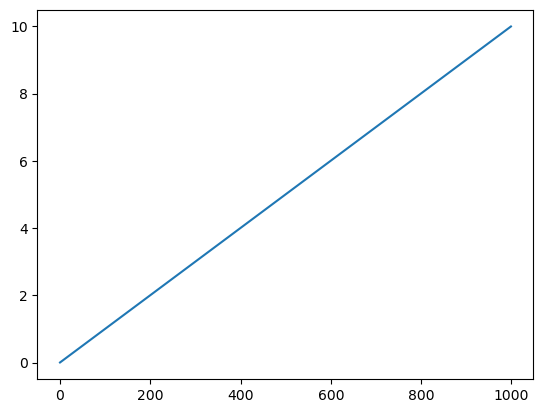

In [66]:
plt.plot(_)

In [88]:
column_mapping = {}
for i in range(361, 721):
    column_mapping[(i - 361)] = (i)

actual_ints1.rename(columns=column_mapping, inplace=True)         

In [93]:
column_mapping = {}
for i in range(722, 1082):
    column_mapping[(i - 722)] = (i)
print(column_mapping)

actual_ints2.rename(columns=column_mapping, inplace=True)    

{0: 722, 1: 723, 2: 724, 3: 725, 4: 726, 5: 727, 6: 728, 7: 729, 8: 730, 9: 731, 10: 732, 11: 733, 12: 734, 13: 735, 14: 736, 15: 737, 16: 738, 17: 739, 18: 740, 19: 741, 20: 742, 21: 743, 22: 744, 23: 745, 24: 746, 25: 747, 26: 748, 27: 749, 28: 750, 29: 751, 30: 752, 31: 753, 32: 754, 33: 755, 34: 756, 35: 757, 36: 758, 37: 759, 38: 760, 39: 761, 40: 762, 41: 763, 42: 764, 43: 765, 44: 766, 45: 767, 46: 768, 47: 769, 48: 770, 49: 771, 50: 772, 51: 773, 52: 774, 53: 775, 54: 776, 55: 777, 56: 778, 57: 779, 58: 780, 59: 781, 60: 782, 61: 783, 62: 784, 63: 785, 64: 786, 65: 787, 66: 788, 67: 789, 68: 790, 69: 791, 70: 792, 71: 793, 72: 794, 73: 795, 74: 796, 75: 797, 76: 798, 77: 799, 78: 800, 79: 801, 80: 802, 81: 803, 82: 804, 83: 805, 84: 806, 85: 807, 86: 808, 87: 809, 88: 810, 89: 811, 90: 812, 91: 813, 92: 814, 93: 815, 94: 816, 95: 817, 96: 818, 97: 819, 98: 820, 99: 821, 100: 822, 101: 823, 102: 824, 103: 825, 104: 826, 105: 827, 106: 828, 107: 829, 108: 830, 109: 831, 110: 832,

In [94]:
column_mapping = {}
for i in range(1083, 1443):
    column_mapping[(i - 1083)] = (i)
print(column_mapping)

actual_ints3.rename(columns=column_mapping, inplace=True)    

{0: 1083, 1: 1084, 2: 1085, 3: 1086, 4: 1087, 5: 1088, 6: 1089, 7: 1090, 8: 1091, 9: 1092, 10: 1093, 11: 1094, 12: 1095, 13: 1096, 14: 1097, 15: 1098, 16: 1099, 17: 1100, 18: 1101, 19: 1102, 20: 1103, 21: 1104, 22: 1105, 23: 1106, 24: 1107, 25: 1108, 26: 1109, 27: 1110, 28: 1111, 29: 1112, 30: 1113, 31: 1114, 32: 1115, 33: 1116, 34: 1117, 35: 1118, 36: 1119, 37: 1120, 38: 1121, 39: 1122, 40: 1123, 41: 1124, 42: 1125, 43: 1126, 44: 1127, 45: 1128, 46: 1129, 47: 1130, 48: 1131, 49: 1132, 50: 1133, 51: 1134, 52: 1135, 53: 1136, 54: 1137, 55: 1138, 56: 1139, 57: 1140, 58: 1141, 59: 1142, 60: 1143, 61: 1144, 62: 1145, 63: 1146, 64: 1147, 65: 1148, 66: 1149, 67: 1150, 68: 1151, 69: 1152, 70: 1153, 71: 1154, 72: 1155, 73: 1156, 74: 1157, 75: 1158, 76: 1159, 77: 1160, 78: 1161, 79: 1162, 80: 1163, 81: 1164, 82: 1165, 83: 1166, 84: 1167, 85: 1168, 86: 1169, 87: 1170, 88: 1171, 89: 1172, 90: 1173, 91: 1174, 92: 1175, 93: 1176, 94: 1177, 95: 1178, 96: 1179, 97: 1180, 98: 1181, 99: 1182, 100: 1183

In [95]:
column_mapping = {}
for i in range(1444, 1804):
    column_mapping[(i - 1444)] = (i)

actual_ints4.rename(columns=column_mapping, inplace=True)    

In [98]:
data_v = pd.concat([actual_ints, actual_ints1, actual_ints2, actual_ints3, actual_ints4], axis = 1)
data_v

0     1     2     3     4     5     6     7     8     9     ...  \
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
996   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
997   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

             1794          1795          1796          1797          1798  \
0    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3    1.187702e-24  1.187702e-24  1.187702e-24  1.209414e-24  1.261485e-24   
4    2.447438e-24  2.447438e-24  2.447438e-24  2.457639e-24  2.482103e-24   
..            ...           ...           ...           ...           ...   
995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
996  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
998  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

             1799          1800          1801          1802          1803  
0    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
2    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
3    2.584517e-24  2.584517e-24  2.584517e-24  2.584517e-24  2.584517e-24  
4    5.245128e-24  5.245128e-24  5.245128e-24  5.245128e-24  5.245128e-24  
..            ...           ...           ...           ...           ...  
995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
996  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
998  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  

[1000 rows x 1800 columns]

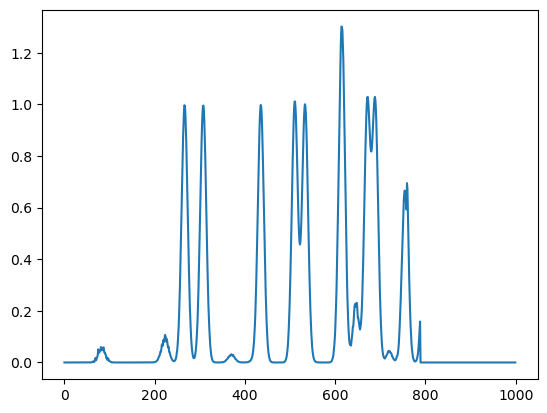

In [100]:
plt.plot(data_v[800])

In [151]:
import IsoDAT2D as iso
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimDAT2D as sim
import os
import IsoDAT2D as iso
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.decomposition import NMF
import dask
import glob as glob
from tifffile import imread, imshow
import warnings
import dask
import pickle 
from dask.distributed import Client, as_completed, get_worker

#data = pd.read_csv('integrations_more.csv')

def attempt(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q

def attempt2(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q, fit_compos, NMF_data


def Run_NMF(Real_Data, init= None, solver = 'cd', beta_loss = 'frobenius', itear = 1000, show = False):
    
    """" Comparison of multiple components without manually comparing
    multiple components all at once. There are a few ways that this can be done. One way
    is to take the residuals of the datasets with themselves to see which is the closests to the 
    "correct" component. This may only be done on sample data potentially. Could include a 
    simulated dataset of what the standing component should look like give or take some 
    variations in the data. When the residuals are taken if it is less than some given 
    percentage the would be the dataset/NMF component to use further. There may be multiple
    thus having to go in manually to find differences. 
    
    To do this, will need to import the simulated XRD pattern from VESTA and then take the residual differences
    of each component and compared to the simulated pattern. Will have the program spit out the compnents that
    meet the cutoff. """

    In = init
    Solve = solver
    Beta = beta_loss
    It = itear


    # calcs = []
    
    # for i in range(1, Real_Data.shape[1]):
    #     calcs.append(attempt(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It))
    #     print('The beta-divergence for', i, 'components is', calcs[i-1], '%\n')
    #     print(f'Completed {i} out of {Real_Data.shape[1]}')
        
    # calcs = np.array(calcs)
    # min_Q = np.min(calcs)
    # noc = np.where(calcs == min_Q)
    # noc_2 = noc[0]
    # number_of_components = noc_2[0] +1

    Divergence, compos, NMF_Data_2 = attempt2(Real_Data, Real_Data.shape[1], len(Real_Data.columns), In, Solve, Beta)
            
    
    print('The beta-divergence is: ', Divergence, '%\n','The final number of components used were',len(Real_Data.columns), '\n') 
    
    
    m = pd.DataFrame(compos)
    m = m.T
    
    if show == True:
        plt.figure(figsize = (5,5))
        colors = plt.cm.magma(np.linspace(0,1, len(Real_Data.columns)))
        i = 0
        while i < len(Real_Data.columns):
            plt.plot(m[i], c = colors[i], alpha = 0.7)
            i = i+1
    
    return m,NMF_Data_2, Divergence

def AggCluster(Number_Clusters, data):
    
    """A program that will take in the type of scikitlearn clustering algorithm
        desired and the number of clusters as well as the data in a numpy array
        and output the associated clusters with the original data. This will make
        the 'latent' space from the clustering algorithms have more meaning"""

    from sklearn.cluster import AgglomerativeClustering
    Make_Clusters= AgglomerativeClustering(n_clusters = Number_Clusters, compute_distances=True)
    y_kmeans = Make_Clusters.fit_predict(data)
    information = Make_Clusters.fit(data)
    parameter = information.distances_
    
    x = 0
    Understanding_data = {"Cluster_Number":[], "Int_Angle":[]}
    while x < len(data):
        Understanding_data["Cluster_Number"].append(y_kmeans[x])
        Understanding_data["Int_Angle"].append(data[x])
        x = x + 1

    # Create a dictionary to store data points for each cluster
    cluster_data = {}
    for q in range(Number_Clusters):
        cluster_data[q] = []

    for i in range(len(data)):
        cluster_num = Understanding_data["Cluster_Number"][i]
        data_point = Understanding_data["Int_Angle"][i]
        cluster_data[cluster_num].append(data_point)

    return Understanding_data, cluster_data


def smooth_components(Identified_components, filter_strength = 2, show = False):
    '''A function that will smooth the components identified from the agglomerative clustering algorithm'''
    
    # Importing required library
    from scipy.signal import savgol_filter
    
    # Defining a dictionary that maps filter strength to the number of points for the smoothing window
    strength_to_points = {1: 3, 2: 5, 3: 7, 4: 11, 5: 15}
    
    # Retrieving the number of points for the smoothing window based on the filter strength provided
    points = strength_to_points.get(filter_strength)

    # Applying Savitzky-Golay filter to smooth the identified components by taking their average along the columns
    smoothed_compos = savgol_filter(np.mean(Identified_components, axis = 0), points, 1)
    
    # If show argument is True, plotting the original components, their average, and the smoothed components
    if show == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        ax1.plot(Identified_components.T, c = 'k', linewidth = 2, alpha = 0.7)
        ax1.set_title('Identified Components')
        ax1.set_ylabel('Intensity')
        ax2.plot(np.mean(Identified_components, axis = 0), c = 'r', linewidth = 2, alpha = 0.7)
        ax2.set_ylabel('Intensity')
        ax2.set_title('Mean of Identified Components')
        ax3.plot(smoothed_compos, c = 'g', linewidth = 2, alpha = 0.7, label = 'Smoothed Component')
        ax3.scatter(np.arange(len(np.mean(Identified_components, axis = 0))), np.mean(Identified_components, axis = 0), c = 'r', s = 10, 
                    label = 'Mean Component')
        ax3.set_xlabel('Data Points')
        ax3.set_title('Smoothed Component')
        ax3.set_ylabel('Intensity')
        ax3.legend()
    
    # Returning the smoothed components
    return smoothed_compos

def run_nmfac(Data, clusters = 5):
    """A function that will run the NMF algorithm and then cluster with agglomerative clustering the components and returns the 
        identified components for later PDF analysis. The function starts with a random initializer
        that will be used to initialize the NMF algorithm. The user can decide how many iterations the 
        initializer takes. Then it will go through the NMF algorithm and compare the beta divergences of all the
        initializations and select the one with the lowest. By default, there is no initializer and the NMF algorithm
        uses preset parameters to run the algorithm. """
        
        #NMF Parameter Values
        
    import warnings
    import numpy as np
    warnings.filterwarnings("ignore")
    
    
    init_params = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
    solver_params = ['cd', 'mu']
    beta_loss_params = ['frobenius', 'kullback-leibler']
    tol_params = np.arange(0.00001, 0.01, 0.0001)
    max_iter_params = np.arange(100, 10000, 100)
    shuffle_params = [True, False]
    
    percentage =  100 # Change this to the desired percentage

    # Calculate the number of datasets based on the percentage
    num_datasets = int(len(Data.columns) * (percentage / 100))

    # Randomly select the dataset indices
    random_indices = np.random.choice(len(Data.columns), size=num_datasets, replace=False)
    
    transposed_data = Data.T

    # Select the randomly chosen datasets
    random_datasets_transposed = transposed_data.iloc[random_indices]
    
    random_datasets = random_datasets_transposed.T

    # Print the randomly selected datasets
    print(random_datasets)
        
    weights, components, beta = Run_NMF(random_datasets, show = True)
    AggComponents = np.array(components).T
    Dictionary, found_compos = AggCluster(clusters, AggComponents)
    
    found_compos = np.array(found_compos)
    
        
        
    found_compos = np.array(found_compos)
            
    return Dictionary, found_compos

     64            803           700   99            865           784   \
0     0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   
1     0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   
2     0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   
3     0.0  1.607604e-23  1.401841e-25   0.0  7.343621e-26  2.175421e-23   
4     0.0  1.605169e-23  1.401841e-25   0.0  7.331130e-26  2.173939e-23   
..    ...           ...           ...   ...           ...           ...   
995   0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   
996   0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   
997   0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   
998   0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   
999   0.0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000e+00   

             1230          817           1509          1249  ...  \
0    0.000000e+00  0.000000e+00

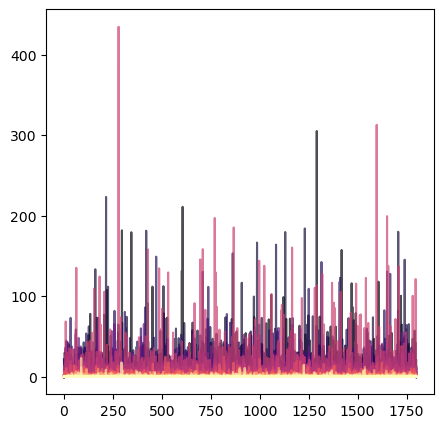

In [152]:
my_dict, my_comps = run_nmfac(data_v, clusters = 35)

cluster_groups = {}
for cluster_num in set(my_dict['Cluster_Number']):
    cluster_groups[cluster_num] = []

# Group the data based on cluster numbers
for cluster_num, int_angle in zip(my_dict['Cluster_Number'], my_dict['Int_Angle']):
    cluster_groups[cluster_num].append(int_angle)
    

# Save
#np.save('cluster_try_two.npy', my_dict) 

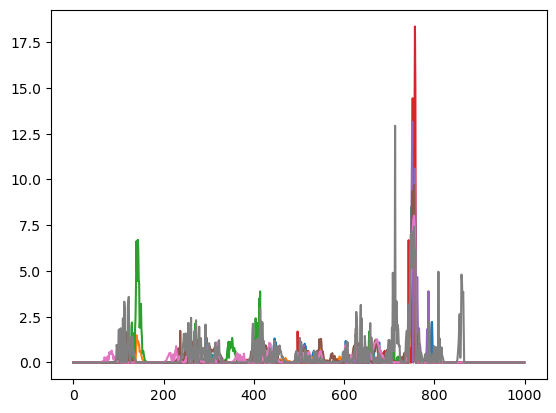

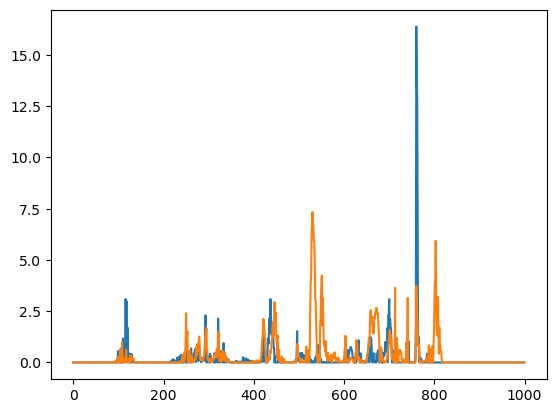

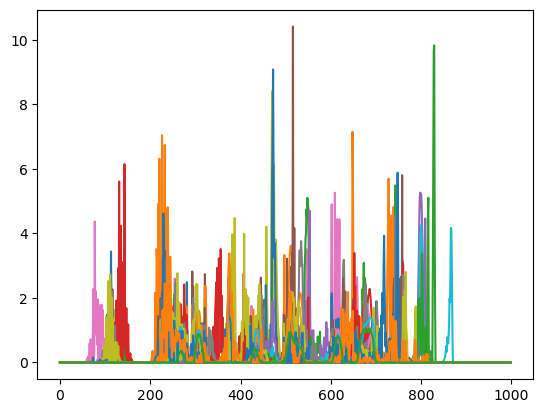

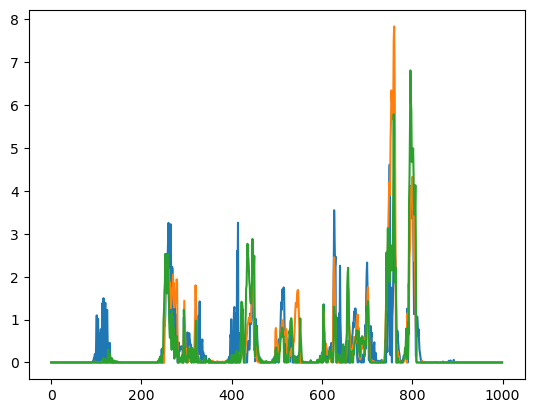

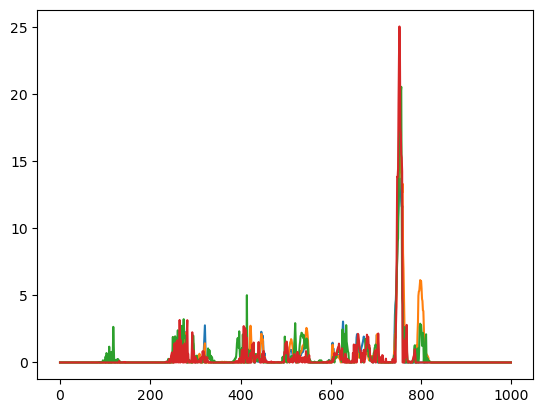

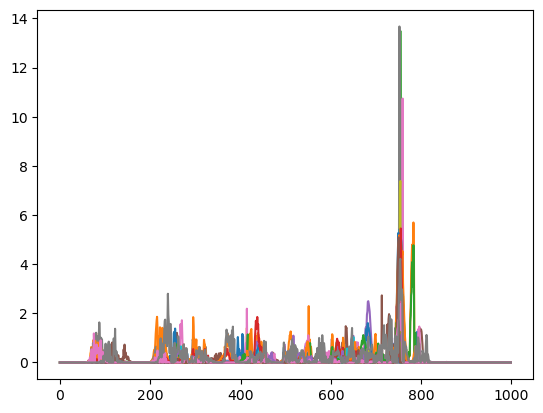

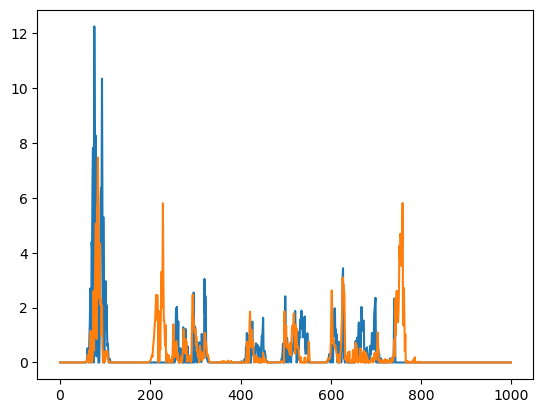

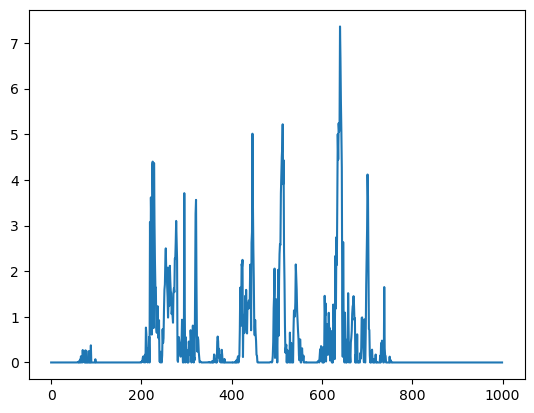

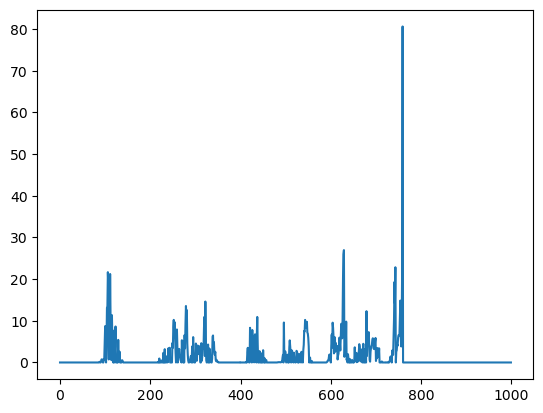

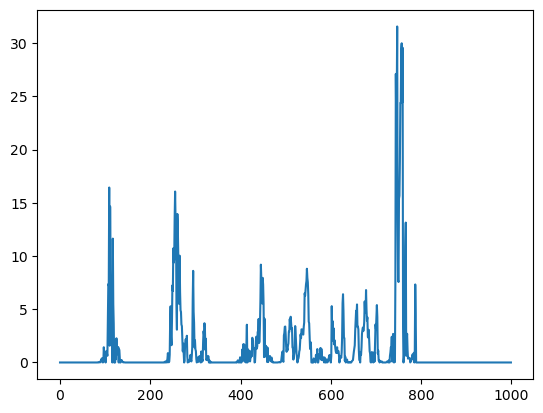

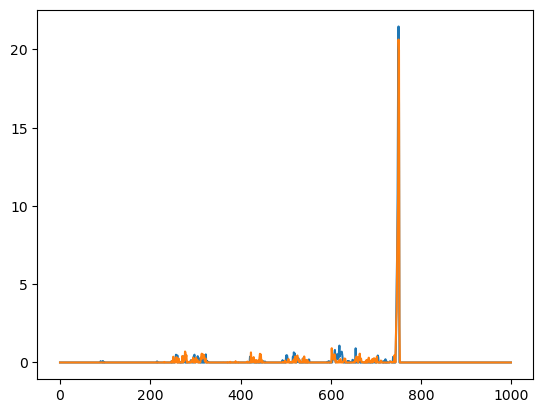

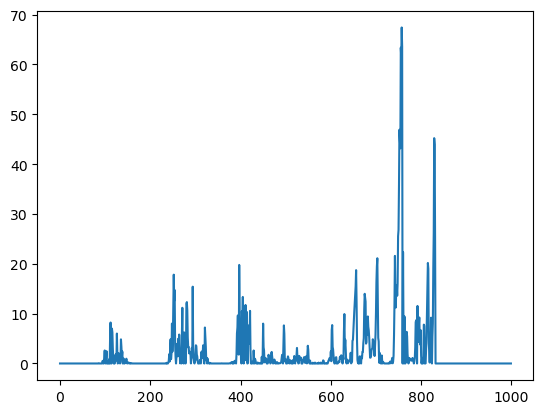

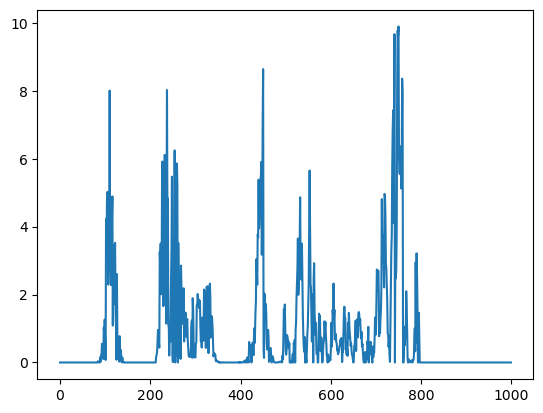

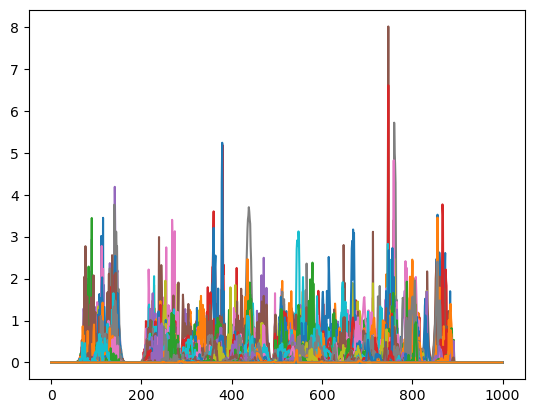

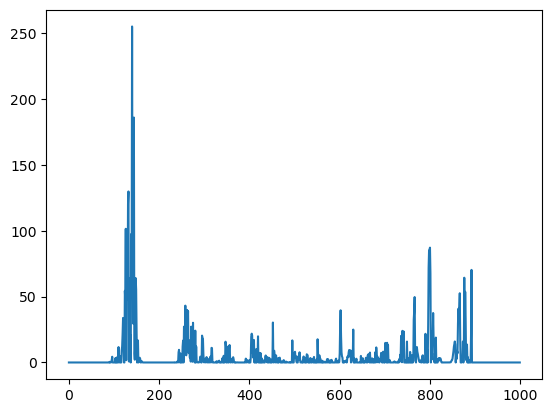

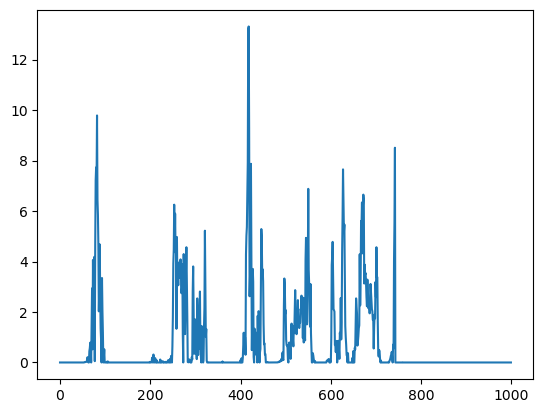

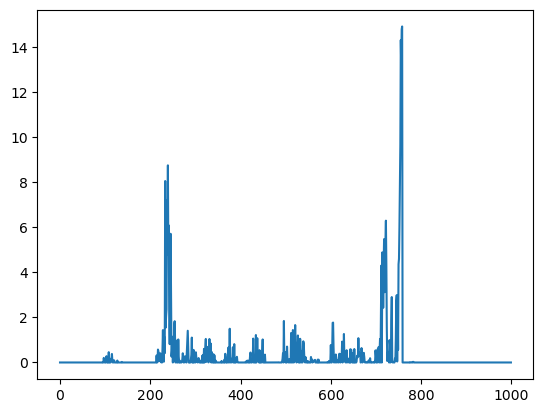

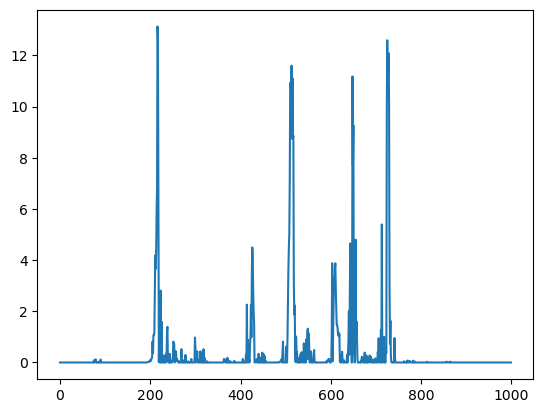

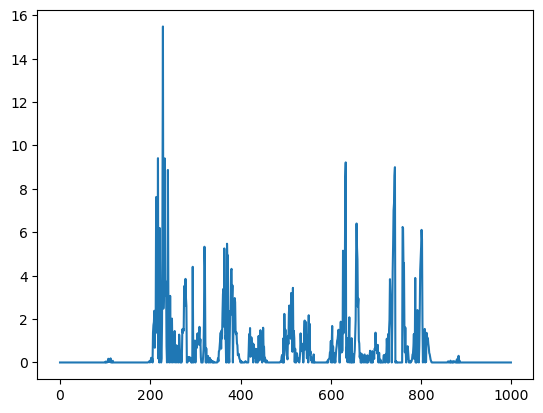

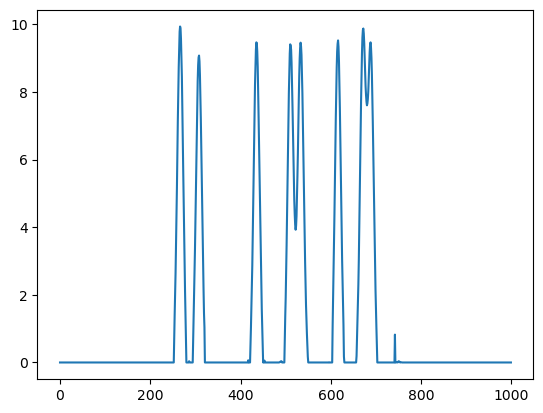

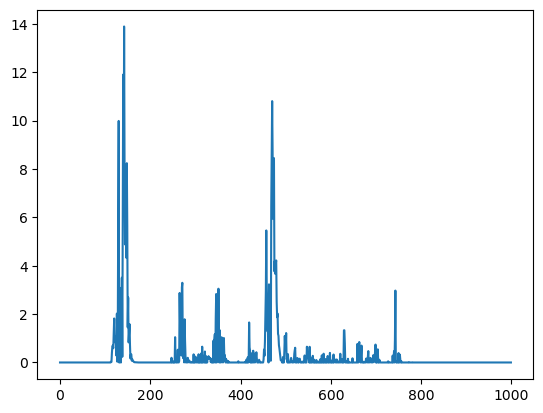

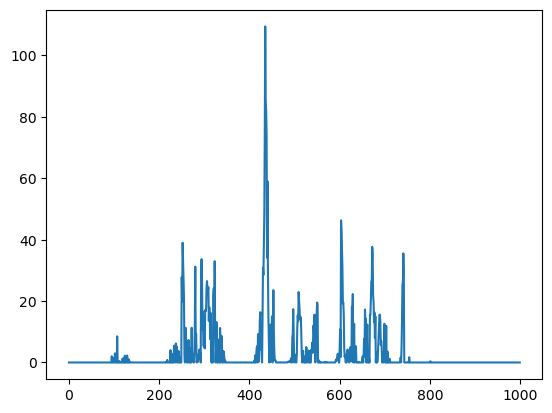

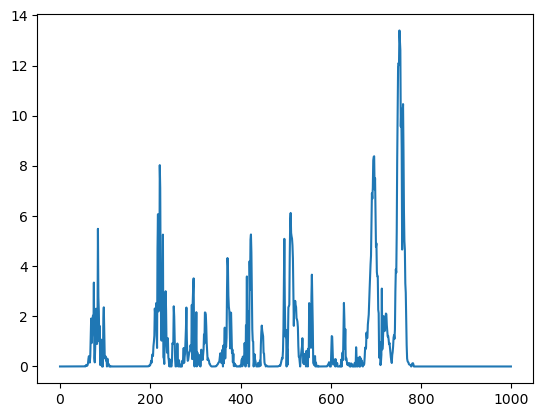

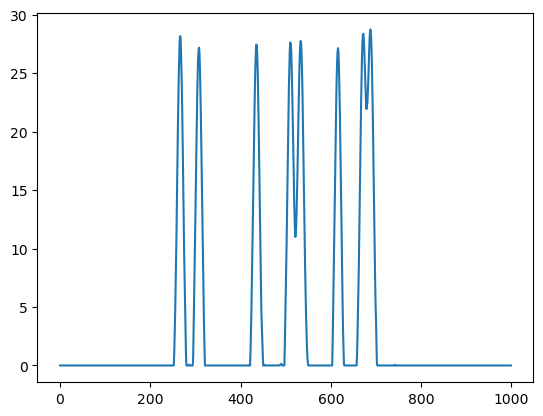

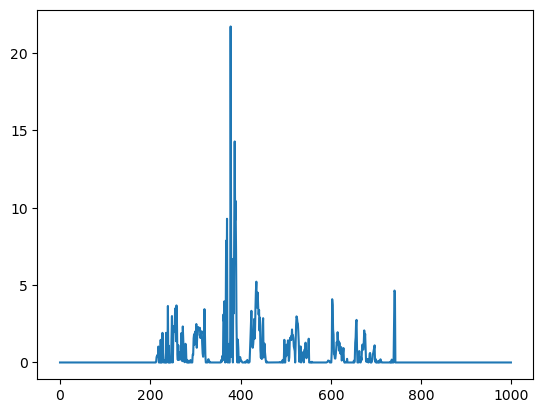

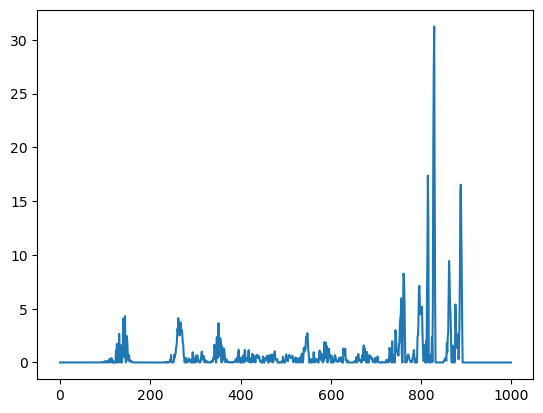

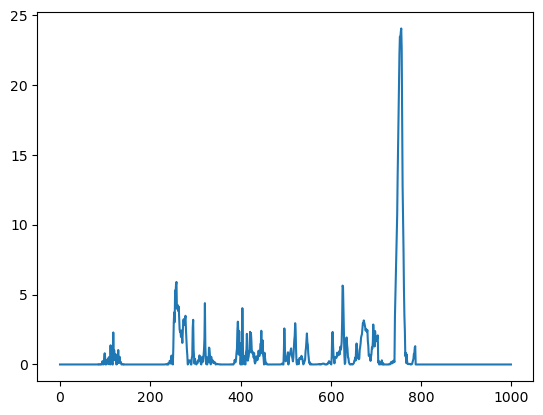

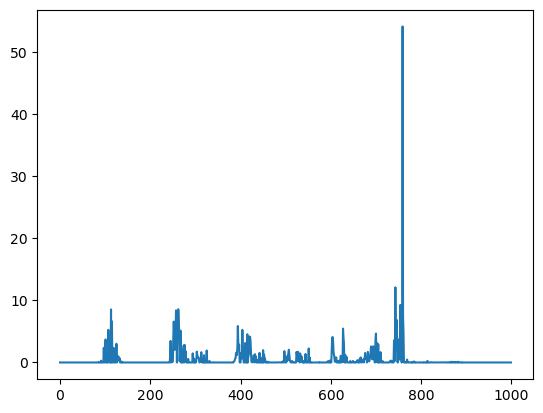

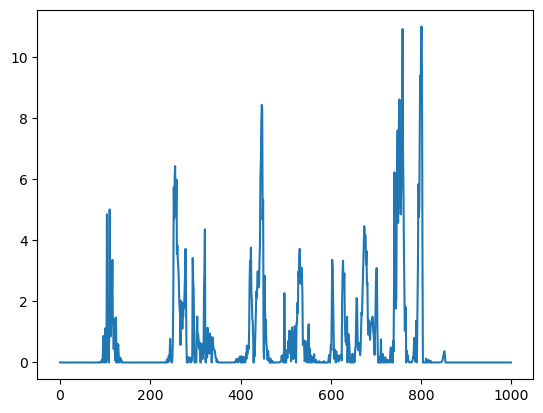

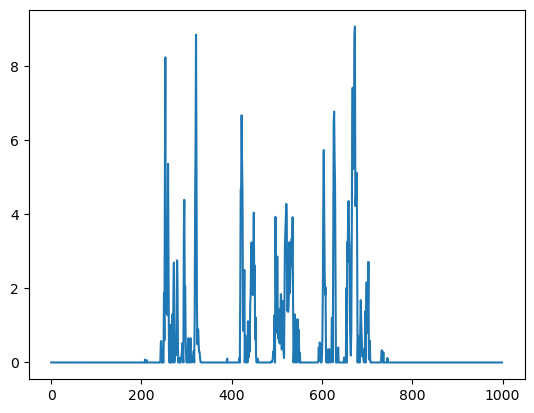

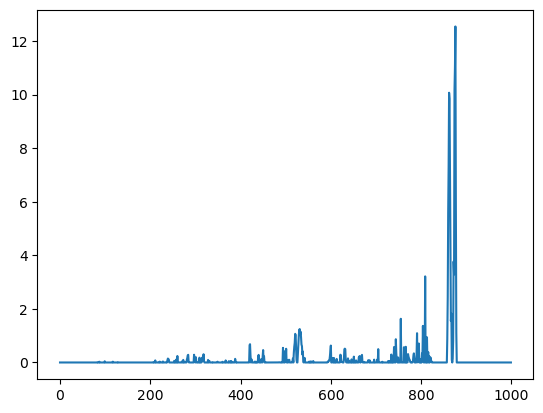

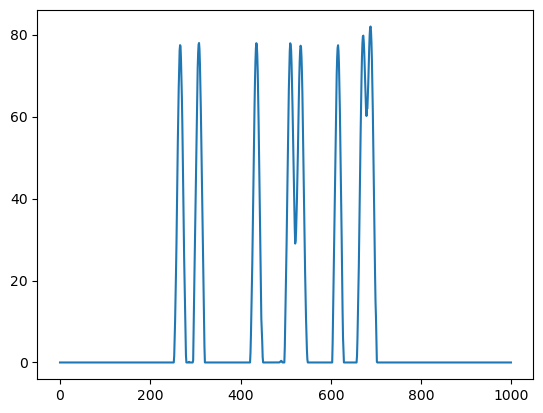

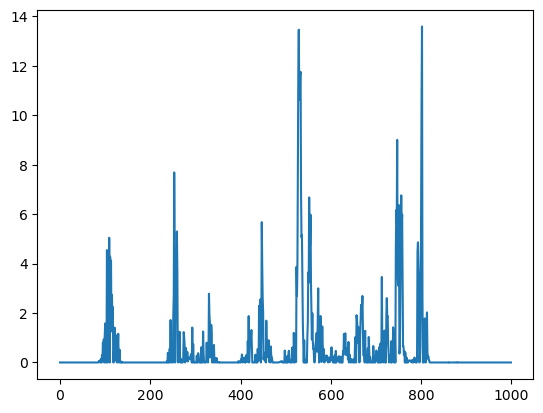

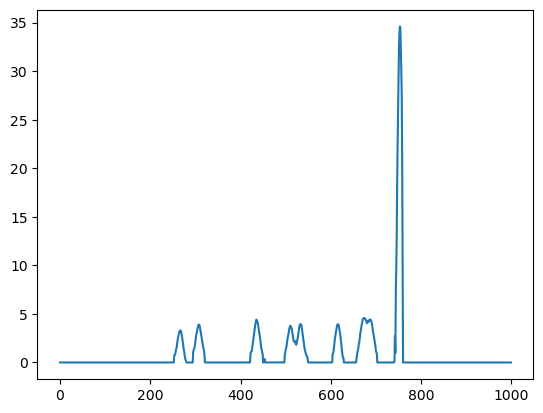

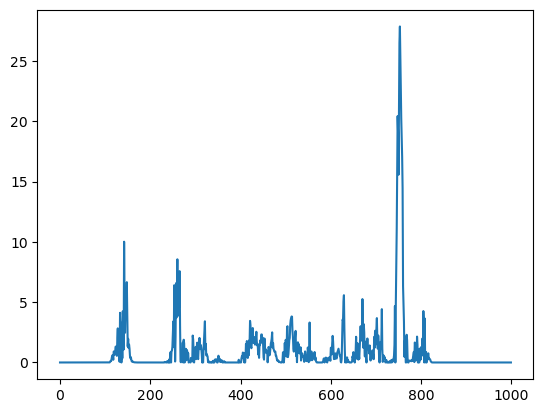

In [154]:
import matplotlib.pyplot as plt

for i in range(0, 35):
    plt.figure()
    for value in cluster_groups[i]:
        plt.plot(value)
    #plt.show()

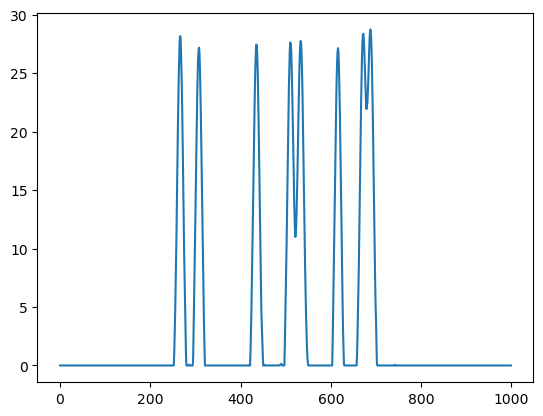

In [161]:
for value in cluster_groups[23]:
    plt.plot(value)

plt.show()

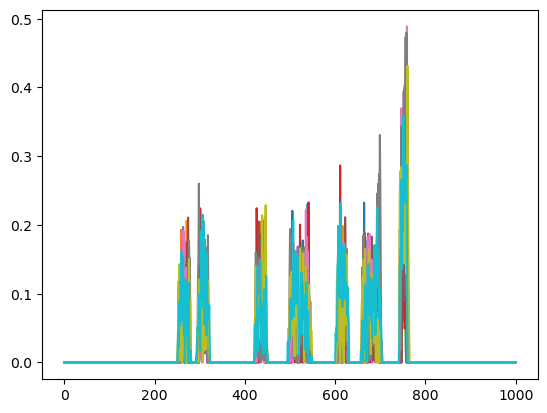

In [142]:
for value in cluster_groups[2]:
    plt.plot(value)

plt.show()

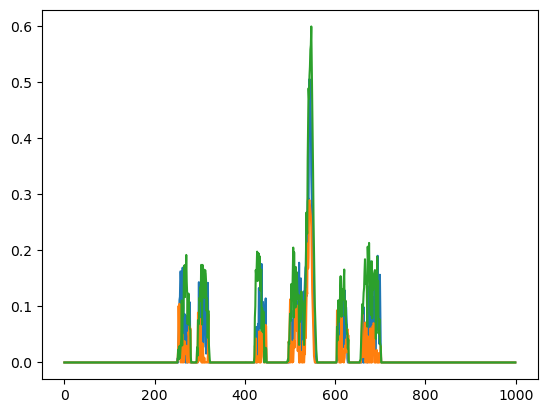

In [143]:
for value in cluster_groups[3]:
    plt.plot(value)

plt.show()

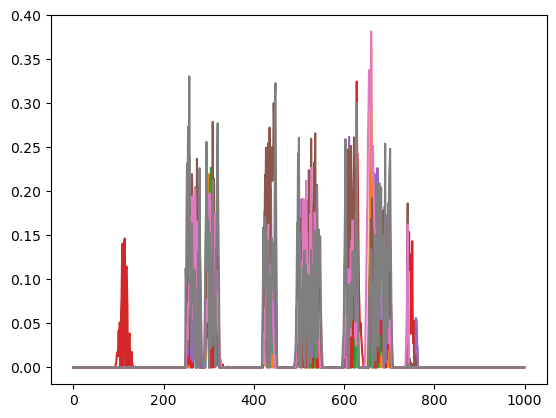

In [144]:
for value in cluster_groups[4]:
    plt.plot(value)

plt.show()

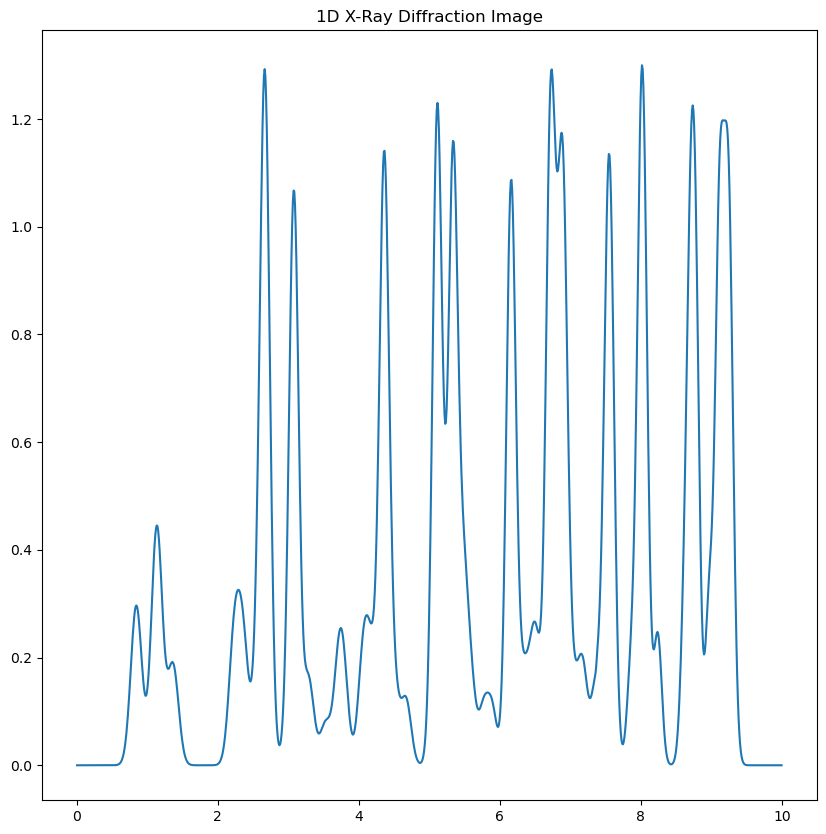

In [171]:
q, raw_data = integrate_image(data, .4, .4e-10, resolution = 1000, show = True, radial_range = (0, 10))

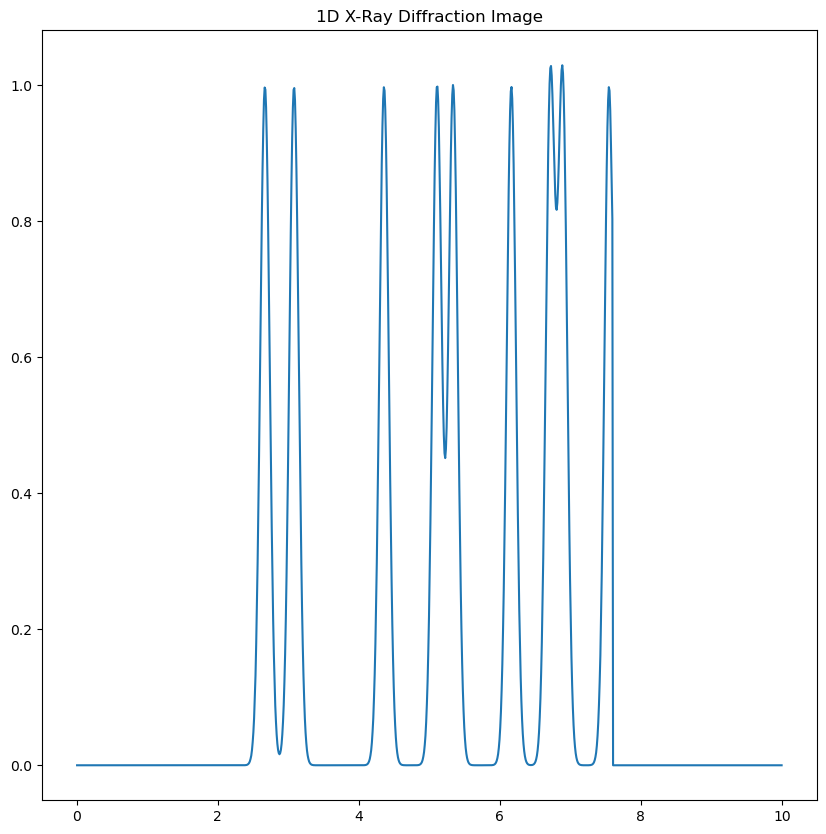

In [170]:
q, pure_data = integrate_image(pure, .4, .4e-10, resolution = 1000, mask = mask_two, show = True, radial_range = (0, 10))

In [169]:
_, raw = raw_data
_, pure = pure_data

ValueError: too many values to unpack (expected 2)

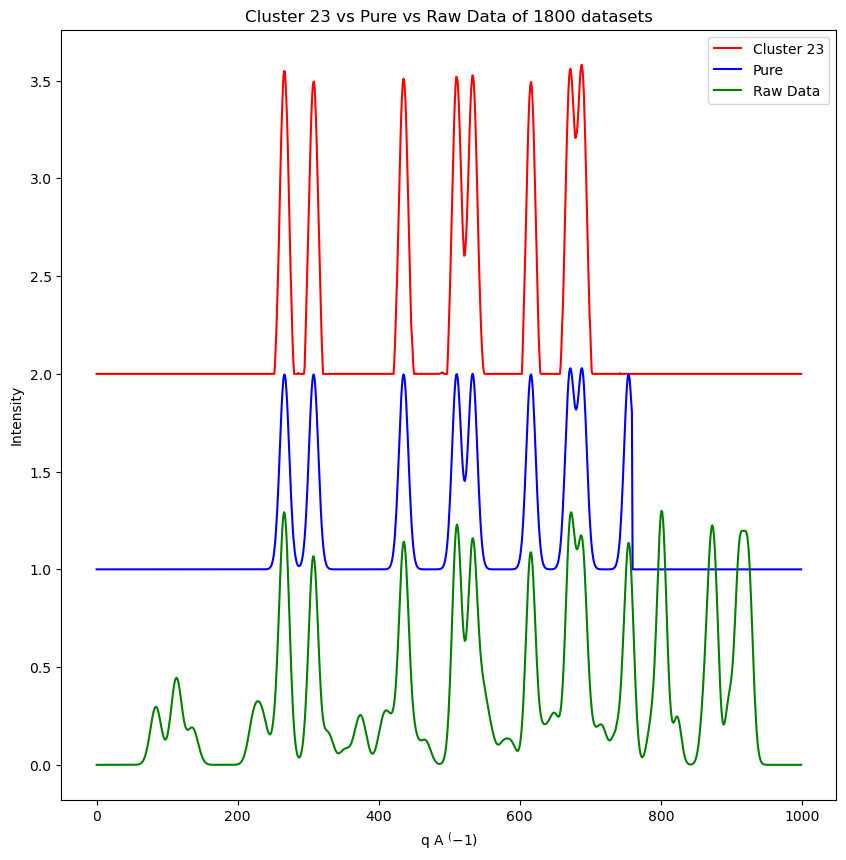

In [183]:
plt.figure(figsize = (10, 10))
plt.plot((cluster_groups[23][0]*.055)+2, c= 'r', label = 'Cluster 23')
plt.plot(pure_data+1, c = 'b', label = 'Pure')
plt.plot(raw_data, c = 'g', label = 'Raw Data')
plt.legend()
plt.title('Cluster 23 vs Pure vs Raw Data of 1800 datasets')
plt.ylabel('Intensity')
plt.xlabel('q A $^(-1)$')
plt.show()